In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_coint_rank, select_order
# from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.tsa.vector_ar import util
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    int_like,
    string_like,
)
import pandas as pd

### Q3

In [2]:
def generate_lagged_inp(X,max_lag):
    X = np.array(X)
    lag_inputs = np.zeros((len(X) - max_lag, max_lag))
    for i in range(max_lag):
        lag_inputs[:, i] = X[max_lag - 1 - i: -1 - i]
    return lag_inputs

def fit_ols_model(X, Y, intercept = True):
    if intercept:
        X = sm.add_constant(X)  # Add a constant term to the exogenous variables
    model = sm.OLS(Y,X)
    fitted_model = model.fit()
    return fitted_model

class ARMAProcess:
    def __init__(self, ar_params, ma_params):
        self.ar_params = ar_params
        self.ma_params = ma_params
        
    def generate_ARMA(self,n):
        arma_process = ArmaProcess(self.ar_params, self.ma_params) ## polynomials to pass
        return arma_process.generate_sample(n)
    
    def fit_model(self, data):
        ar_model = sm.tsa.ARMA(data, order=(len(self.ar_params), len(self.ma_params)))
        fitted_model = ar_model.fit()
        return fitted_model
        
    def MC_sim_ARMA(self,MC_length,max_lag):
        estim_models = []
        IV_estims = []
        relev_covar = []
        for i in range(MC_length):
            generated_samples = self.generate_ARMA(1000)
            y = generated_samples 
            X = generate_lagged_inp(generated_samples,max_lag)
            Z = generate_lagged_inp(X.reshape(-1,),1) ### Get x_(t-1) as the instrument variable because E(x_(t-1)*x_t) !=0 while its exogenous with erros
            relev_covar.append(np.mean(X[1:]*Z))
            OLS_fit = fit_ols_model(X,y[max_lag:],intercept = False)
            IV_estim = np.linalg.inv(Z.T @ X[1:]) @ Z.T @ y[max_lag + 1:]
            estim_models.append(OLS_fit)
            IV_estims.append(IV_estim)
        return estim_models, IV_estims, relev_covar

In [3]:
# Example usage
ar_params = [0.8]  # AR parameter
ma_params = [0.7]   # MA parameters
ar = np.r_[1,-np.array(ar_params)]
ma = np.r_[1,np.array(ma_params)]
arma_process = ARMAProcess(ar, ma)
OLS_sims_ARMA,IV_estims,relev_covar = arma_process.MC_sim_ARMA(1000,1)
#residuals = OLS_sims_ARMA[100].resid
coeffs = [sim_param.params[0] for sim_param in OLS_sims_ARMA]
print(f"E(Xz) = {np.mean(relev_covar)} across all simulations")

E(Xz) = 6.511838017233015 across all simulations


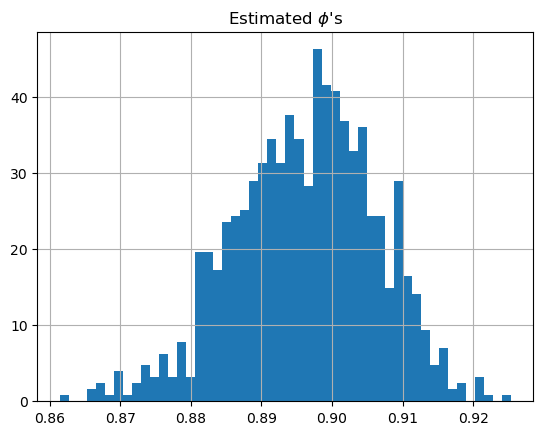

In [4]:
plt.hist(np.array(coeffs).reshape(-1,), bins = 50, density = True)
plt.title(f"Estimated $\phi$'s")
plt.grid()

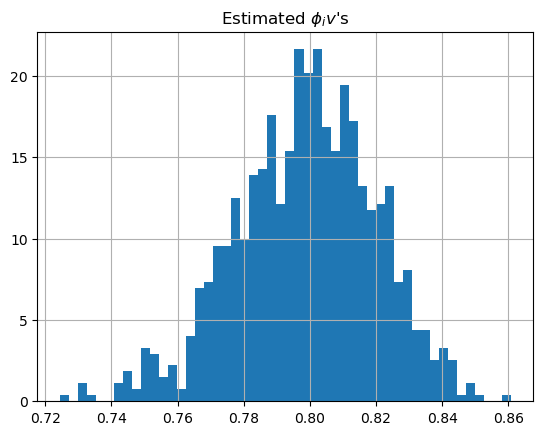

In [5]:
plt.hist(np.array(IV_estims).reshape(-1,), bins = 50, density = True)
plt.title(f"Estimated $\phi_iv$'s")
plt.grid()

### Observations

- Clearly for the OLS estimator, there is a bias(shifted towards $0.9$) and inconsistency($E(Xz) != 0$) caused by problem mis-specification as seen in the first plot. The reason being we are trying to fit an ARMA process under AR assumptions
- Considering the instrumental variable like $x_{t-1}$ as its correlated to $x$ and uncorrelated with the error residuals, performing $IV$ estimation does improve the situation as the the estimated $\hat{\beta}$ is close to the true value
- The estimator is also consistent with the plot shown above

In [6]:
########################################################################################################################
### VAR representation of VECM
def var_rep(alpha, beta, gamma):
    """
    K: number of variables
    L: number of VECM lags
    alpha: Kx1 vector of coefficients of cointegrating vector (\gamma)
    beta:  Kx1 cointegrating vector (\alpha)
    gamma: Kx(LK) matrix of coefficients of lagged term [Psi_1,...,Psi_L] where Psi_i is a KxK matrix
    """
    pi = alpha.dot(beta.T)
    K = len(beta)
    L = int(gamma.shape[1]/gamma.shape[0])+1
    A = np.zeros((L, K, K))
    A[0] = pi + np.identity(K)
    if gamma.size > 0:
        A[0] += gamma[:, :K]
        A[L - 1] = -gamma[:, K * (L - 2) :]
        for i in range(1, L - 1):
            A[i] = (
                gamma[:, K * i : K * (i + 1)]
                - gamma[:, K * (i - 1) : K * i]
            )
    return A
########################################################################################################################


########################################################################################################################
def varsim(coefs, intercept, sig_u, steps=100, initial_values=None, seed=None, nsimulations=None):
    """
    Simulate VAR(p) process, given coefficients and assuming Gaussian noise

    Parameters
    ----------
    coefs : ndarray
        Coefficients for the VAR lags of endog.
    intercept : None or ndarray 1-D (neqs,) or (steps, neqs)
        This can be either the intercept for each equation or an offset.
        If None, then the VAR process has a zero intercept.
        If intercept is 1-D, then the same (endog specific) intercept is added
        to all observations.
        If intercept is 2-D, then it is treated as an offset and is added as
        an observation specific intercept to the autoregression. In this case,
        the intercept/offset should have same number of rows as steps, and the
        same number of columns as endogenous variables (neqs).
    sig_u : ndarray
        Covariance matrix of the residuals or innovations.
        If sig_u is None, then an identity matrix is used.
    steps : {None, int}
        number of observations to simulate, this includes the initial
        observations to start the autoregressive process.
        If offset is not None, then exog of the model are used if they were
        provided in the model
    initial_values : array_like, optional
        Initial values for use in the simulation. Shape should be
        (nlags, neqs) or (neqs,). Values should be ordered from less to
        most recent. Note that this values will be returned by the
        simulation as the first values of `endog_simulated` and they
        will count for the total number of steps.
    seed : {None, int}
        If seed is not None, then it will be used with for the random
        variables generated by numpy.random.
    nsimulations : {None, int}
        Number of simulations to perform. If `nsimulations` is None it will
        perform one simulation and return value will have shape (steps, neqs).

    Returns
    -------
    endog_simulated : nd_array
        Endog of the simulated VAR process. Shape will be (nsimulations, steps, neqs)
        or (steps, neqs) if `nsimulations` is None.
    """
    rs = np.random.RandomState(seed=seed)
    rmvnorm = rs.multivariate_normal
    p, k, k = coefs.shape
    nsimulations= int_like(nsimulations, "nsimulations", optional=True)
    if isinstance(nsimulations, int) and nsimulations <= 0:
        raise ValueError("nsimulations must be a positive integer if provided")
    if nsimulations is None:
        result_shape = (steps, k)
        nsimulations = 1
    else:
        result_shape = (nsimulations, steps, k)
    if sig_u is None:
        sig_u = np.eye(k)
    ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations).reshape(nsimulations, steps, k)
    result = np.zeros((nsimulations, steps, k))
    if intercept is not None:
        # intercept can be 2-D like an offset variable
        if np.ndim(intercept) > 1:
            if not len(intercept) == ugen.shape[1]:
                raise ValueError('2-D intercept needs to have length `steps`')
        # add intercept/offset also to intial values
        result += intercept
        result[:,p:] += ugen[:,p:]
    else:
        result[:,p:] = ugen[:,p:]

    initial_values = array_like(initial_values, "initial_values", optional=True, maxdim=2)
    if initial_values is not None:
        if not (initial_values.shape == (p, k) or initial_values.shape == (k,)):
            raise ValueError("initial_values should have shape (p, k) or (k,) where p is the number of lags and k is the number of equations.")
        result[:,:p] = initial_values

    # add in AR terms
    for t in range(p, steps):
        ygen = result[:,t]
        for j in range(p):
            ygen += np.dot(coefs[j], result[:,t-j-1].T).T

    return result.reshape(result_shape)
########################################################################################################################


########################################################################################################################
### VECM with known cointegrating vector
def vecm(X, coint_coef, lags, print_output=True, print_short=True):
    
    #number of variables in the system
    K = X.shape[1]

    X_diff = X.diff(1)
    #add lag terms
    for col in list(X_diff):
        for i in range(lags):
            X_diff[col + "(-" + str(i + 1)+")"] = X_diff[col].shift(i + 1)  
    
    if type(coint_coef)==list:
        coint_coef = np.array(coint_coef)
    
    z = X @ coint_coef
    if type(z) == pd.Series:
        z = z.to_frame()
    z.columns = ['e.c.']
    
    fit_ls = []
    for i in range(K):
        # X = X_diff.iloc[:,K:]
        XX = pd.concat([z.shift(), X_diff.iloc[:,K:]], axis=1)
        # print(['e.c.']+X.columns)
        # XX.columns = ['e.c.']+list(X.columns)
        XX = sm.tools.tools.add_constant(XX)
        Y = X_diff.iloc[:, i]
        ols_model = sm.regression.linear_model.OLS(Y,XX,missing='drop')
        fit_ls.append(ols_model.fit(cov_type='HC0'))

    if print_output:
        # if print_short:
        #     vecm_present(fit_ls)
        # else:
        for f in fit_ls:
            print(f.summary(),'\n')
    return fit_ls

### Q5

In [7]:
class VECM_analysis():
    def __init__(self,alpha,gamma,psi):
        self.alpha = alpha
        self.gamma = np.array(gamma).reshape(-1,1)
        self.psi = psi
        self.var_coeff = var_rep(self.gamma,self.alpha,self.psi)
        
    def VAR_sim(self,cov_w,T):
        var_sim = pd.DataFrame(varsim(self.var_coeff,None,cov_w,steps = T))
        var_sim.columns = ['x1', 'x2']
        return var_sim

    def fit_VECM(self,data,vecm_lags):
        vecm = VECM(data, k_ar_diff=vecm_lags)
        return vecm.fit()

    def fit_best_VAR(self,data):
        var = VAR(data)
        best_lag = var.select_order().bic
        print(f"best lag for VAR is {best_lag}")
        return var.fit(best_lag)
        
alpha = np.array([[1],[-1]])
psi = np.array([[0.2,-0.1],[0,-0.25]])
gammas = [(0,0.3),(0,0.03),(-0.25,0.1),(0,0)]
Ts = [250,2500]
np.random.seed(48)
for gamma in gammas:
    for T in Ts:
        print(f"Fit for Gamma = {gamma} and Sample size = {T}")
        sim = VECM_analysis(alpha,gamma,psi)
        cov_w = np.eye(2)
        sim_data = sim.VAR_sim(cov_w,T)
        print(sim_data.shape)
        print("Fitting VECM")
        fitted_VECM = sim.fit_VECM(sim_data.to_numpy(),1)
        print("Fitting VAR on X")
        fitted_VAR = sim.fit_best_VAR(sim_data.to_numpy())
        print("Fitting VAR on dX")
        dsim_data = sim_data.diff().dropna()
        fitted_dVAR = sim.fit_best_VAR(dsim_data.to_numpy())
        print(f"VECM Gamma vector is given by \n {fitted_VECM.alpha}\n")
        print(f"VAR Coefficients sum is given by {np.sum(np.sum(fitted_VAR.coefs,axis = 2),axis = 0)}\n")
        print(f"VAR fit BIC = {fitted_VAR.bic}")
        print(f"dVAR fit BIC = {fitted_dVAR.bic}\n")

Fit for Gamma = (0, 0.3) and Sample size = 250
(250, 2)
Fitting VECM
Fitting VAR on X
best lag for VAR is 2
Fitting VAR on dX
best lag for VAR is 1
VECM Gamma vector is given by 
 [[-0.02454521]
 [ 0.26966199]]

VAR Coefficients sum is given by [0.9853656  0.98923007]

VAR fit BIC = 0.21388463526907225
dVAR fit BIC = 0.3407327213662969

Fit for Gamma = (0, 0.3) and Sample size = 2500
(2500, 2)
Fitting VECM
Fitting VAR on X
best lag for VAR is 2
Fitting VAR on dX
best lag for VAR is 8
VECM Gamma vector is given by 
 [[0.00911655]
 [0.27510228]]

VAR Coefficients sum is given by [0.9990666  0.99969102]

VAR fit BIC = 0.01424306748234102
dVAR fit BIC = 0.15754973717669438

Fit for Gamma = (0, 0.03) and Sample size = 250
(250, 2)
Fitting VECM
Fitting VAR on X
best lag for VAR is 2
Fitting VAR on dX
best lag for VAR is 1
VECM Gamma vector is given by 
 [[0.00584887]
 [0.02559047]]

VAR Coefficients sum is given by [0.97485857 0.98729833]

VAR fit BIC = 0.4925498488212521
dVAR fit BIC = 0.45

### Key observations for 5a), 5b)

- Clearly, we can see that the VECM estimations for the gamme vector are very close to their true values for both the sample sizes implying robustness in the properties of the estimator( albeit its much more closer in the case of larger values of $T$ )
- The VAR coefficients on the $X$ data also sum to $1$ across a row which is in line with the derivation we did in exercise $2$
- In majority of the cases, we can see that the best lag ranked by bic is given by $2$ and $1$ when we fit for the first difference implying non stationarity / unit root in the default process. This suggests that we should use first difference specification to counter stationarity
- There are few cases where we do see that the first difference series has more lag requirement(especially in the longer series of data) implying that we are doing overdifferencing in this case and in longer sample sizes, we are better off using VAR on default time series for forecasts
- Summarizing, VECM approach is the best in short/long term if one wants to understand how the two processes cointegrate as the estimates are consistent for long or short durations
- However, in the case of $\gamma$ being a $0$ vector, we can see that the cointegration approach doesn't offer much insight apart from the fact that the two time series don't cointegrate. In such a case as well, we can use VAR/dVAR to make forecasts